In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
from shapely.geometry import Point
import geopy.distance
from geopy import distance
from geopy import Point
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import geocoder
import json
import urllib
import urllib.request

In [19]:
#Using Bikes data from Bay Area for the month of Feb 2021
bikes = pd.read_csv('202102-baywheels-tripdata.csv', error_bad_lines=False)
bikes

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,371D557F2479F774,electric_bike,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,NaN,NaN,37.780000,-122.420000,37.780000,-122.420000,casual
1,317BB9662DEA824B,electric_bike,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,NaN,NaN,37.770000,-122.430000,37.800000,-122.420000,casual
2,609E6F07AB922AA2,electric_bike,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,NaN,NaN,37.740000,-122.420000,37.790000,-122.430000,casual
3,D65E1D0040D6B087,electric_bike,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,NaN,NaN,37.770000,-122.500000,37.770000,-122.500000,casual
4,319D9916F6F8128F,electric_bike,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,NaN,NaN,37.780000,-122.510000,37.770000,-122.490000,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member


In [45]:
#Remove all rows with missing geographic information
bikes = bikes[bikes['start_lat'].notnull()]
bikes = bikes[bikes['start_lng'].notnull()]
bikes = bikes[bikes['end_lng'].notnull()]
bikes = bikes[bikes['end_lat'].notnull()]
bikes_full = bikes[bikes['start_station_id'].notnull()]
bikes_full = bikes_full[bikes_full['end_station_id'].notnull()]
bikes_full

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
4029,BD19F002C21065E0,classic_bike,2021-02-26 15:29:27,2021-02-26 15:31:14,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual
4052,6D4ED519944CC5E5,classic_bike,2021-02-24 15:06:14,2021-02-24 15:39:29,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775235,-122.397437,37.764794,-122.394760,member
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760447,-122.410807,37.785453,-122.396512,member
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760488,-122.410707,37.767114,-122.410699,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771951,-122.453705,37.763708,-122.415204,member


Try to do the analysis just for the routes with given station ids for both end and start.

In [46]:
bikes_missing_start_id = bikes[bikes['start_station_id'].isnull()]
bikes_missing_end_id = bikes[bikes['end_station_id'].isnull()]

Form a separate dataframe for routes with either missing end or start id

In [91]:
#Rounding of coordinates to 4th decimal place
bikes['start_lat'] = bikes['start_lat'].round(decimals=4)
bikes['start_lng'] = bikes['start_lng'].round(decimals=4)
bikes['end_lat'] = bikes['end_lat'].round(decimals=4)
bikes['end_lng'] = bikes['end_lng'].round(decimals=4)
bikes

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,371D557F2479F774,electric_bike,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,NaN,NaN,37.780,-122.4200,37.7800,-122.4200,casual
1,317BB9662DEA824B,electric_bike,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,NaN,NaN,37.770,-122.4300,37.8000,-122.4200,casual
2,609E6F07AB922AA2,electric_bike,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,NaN,NaN,37.740,-122.4200,37.7900,-122.4300,casual
3,D65E1D0040D6B087,electric_bike,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,NaN,NaN,37.770,-122.5000,37.7700,-122.5000,casual
4,319D9916F6F8128F,electric_bike,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,NaN,NaN,37.780,-122.5100,37.7700,-122.4900,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.772,-122.4537,37.7637,-122.4152,member
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.772,-122.4537,37.7637,-122.4152,member
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.772,-122.4537,37.7637,-122.4152,member
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.772,-122.4537,37.7637,-122.4152,member


In [47]:
len(bikes_full['start_lat'].unique())

32201

A lot of unique values for start_lat, even though only 456 unique stations.

In [48]:
station = bikes_full[['start_station_id', 'start_lat',
                      'start_lng']].groupby(by=['start_station_id'],
                                            as_index=False).agg({
                                                'start_lat': 'mean',
                                                'start_lng': 'mean'
                                            })
station

,start_station_id,start_lat,start_lng
0,BK-A3,37.851375,-122.252523
1,BK-A7,37.880222,-122.269592
2,BK-B7,37.876573,-122.269528
3,BK-C1,37.870407,-122.299676
4,BK-C5,37.873558,-122.283093
...,...,...,...
450,SJ-Q4,37.309018,-121.899989
451,SJ-Q5,37.311258,-121.896307
452,SJ-Q8,37.317225,-121.884934
453,SJ-Q9,37.318454,-121.883162


Find average Lat/Long values for each unique station.

In [49]:
bikes_full['start_lat'] = bikes_full['start_station_id'].map(
    station.set_index('start_station_id')['start_lat'])
bikes_full['start_lng'] = bikes_full['start_station_id'].map(
    station.set_index('start_station_id')['start_lng'])
bikes_full['end_lat'] = bikes_full['end_station_id'].map(
    station.set_index('start_station_id')['start_lat'])
bikes_full['end_lng'] = bikes_full['end_station_id'].map(
    station.set_index('start_station_id')['start_lng'])
bikes_full

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
4029,BD19F002C21065E0,classic_bike,2021-02-26 15:29:27,2021-02-26 15:31:14,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual
4052,6D4ED519944CC5E5,classic_bike,2021-02-24 15:06:14,2021-02-24 15:39:29,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775214,-122.397477,37.764793,-122.394796,member
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760437,-122.410778,37.785318,-122.396434,member
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760437,-122.410778,37.767100,-122.410662,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member


Change Lat/Long values to the average for each unique station.

In [50]:
len(bikes_full['start_lat'].unique())

455

In [51]:
len(bikes_full['start_lng'].unique())

455

In [52]:
len(bikes_full['end_lng'].unique())

456

In [53]:
len(bikes_full['end_lat'].unique())

456

Reduced the unique start_lat values from 32201 to just 456 now.

In [16]:
for index, row in bikes2.iterrows():
    start = Point((bikes2['start_lat'][index], bikes2['start_lng'][index]))
    minimum = 100
    for index1, row1 in station.iterrows():
        finish = Point(
            (station['start_lat'][index1], station['start_lng'][index1]))
        displacement = distance.geodesic(start, finish).m
        # print(displacement)
        if (displacement <= minimum):
            bikes2['start_station_id'][index] = station['start_station_id'][
                index1]
            bikes2['start_lat'][index] = station['start_lat'][index1]
            bikes2['start_lng'][index] = station['start_lng'][index1]
            minimum = displacement
            #print(displacement)

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

KeyboardInterrupt: 

Attempt to assign start station ids to the rows with Nan values, unfortunately even though this method has time complexity of O(n*m), where m are unique stations as oppsed to O(n^2), its still very slow. 

In [46]:
for index, row in bikes.iterrows():
    start1 = Point((bikes['start_lat'][index], bikes['start_lng'][index]))
    start2 = Point((bikes['end_lat'][index], bikes['end_lng'][index]))
    for index1, row1 in bikes.iterrows():
        finish1 = Point(
            (bikes['start_lat'][index1], bikes['start_lng'][index1]))
        finish2 = Point((bikes['end_lat'][index1], bikes['end_lng'][index1]))
        displacement1 = distance.geodesic(start1, finish1).m
        displacement2 = distance.geodesic(start2, finish2).m
        # print(displacement)
        if displacement1 <= 10.0:
            #print(displacement)
            bikes['start_lat'][index1] = bikes['start_lat'][index]
            bikes['start_lng'][index1] = bikes['start_lng'][index]
        if displacement2 <= 10.0:
            bikes['end_lat'][index1] = bikes['end_lat'][index]
            bikes['end_lng'][index1] = bikes['end_lng'][index]

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel im

KeyboardInterrupt: 

This method is even slower with a complexity of O(n^2)

In [54]:
#Remove all rows with missing geographic information
bikes_full = bikes_full[bikes_full['start_lat'].notnull()]
bikes_full = bikes_full[bikes_full['start_lng'].notnull()]
bikes_full = bikes_full[bikes_full['end_lng'].notnull()]
bikes_full = bikes_full[bikes_full['end_lat'].notnull()]
bikes_full

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
4029,BD19F002C21065E0,classic_bike,2021-02-26 15:29:27,2021-02-26 15:31:14,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual
4052,6D4ED519944CC5E5,classic_bike,2021-02-24 15:06:14,2021-02-24 15:39:29,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775214,-122.397477,37.764793,-122.394796,member
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760437,-122.410778,37.785318,-122.396434,member
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760437,-122.410778,37.767100,-122.410662,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member


In [59]:
bikes_full['displacement'] = 0
# Get the displacement for each route
for index, row in bikes_full.iterrows():
    start = Point(
        (bikes_full['start_lat'][index], bikes_full['start_lng'][index]))
    finish = Point((bikes_full['end_lat'][index], bikes_full['end_lng'][index]))
    bikes_full['displacement'][index] = distance.geodesic(start, finish)
# print(bikes2['displacement'][index])
bikes_full

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,displacement
4029,BD19F002C21065E0,classic_bike,2021-02-26 15:29:27,2021-02-26 15:31:14,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual,0.0 km
4052,6D4ED519944CC5E5,classic_bike,2021-02-24 15:06:14,2021-02-24 15:39:29,Vine St at Shattuck Ave,BK-A7,Vine St at Shattuck Ave,BK-A7,37.880222,-122.269592,37.880222,-122.269592,casual,0.0 km
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775214,-122.397477,37.764793,-122.394796,member,1.1804897248801203 km
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760437,-122.410778,37.785318,-122.396434,member,3.037043165366727 km
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760437,-122.410778,37.767100,-122.410662,member,0.7396375125648845 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km


In [60]:
bikes_full = bikes_full[bikes_full['displacement'] != 0.0]
bikes_full

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,displacement
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775214,-122.397477,37.764793,-122.394796,member,1.1804897248801203 km
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760437,-122.410778,37.785318,-122.396434,member,3.037043165366727 km
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760437,-122.410778,37.767100,-122.410662,member,0.7396375125648845 km
10564,EF8B274C5CD4559E,electric_bike,2021-02-22 18:24:57,2021-02-22 18:50:10,Utah St at 24th St,SF-Q26,24th St at Bartlett St,SF-Q23-3,37.753243,-122.405496,37.752131,-122.419883,member,1.2738149778077092 km
10565,A896A2BE15365157,classic_bike,2021-02-22 13:16:00,2021-02-22 13:21:37,19th St at Florida St,SF-O25-1,16th St Mission BART Station 2,SF-N22-1B,37.760437,-122.410778,37.764854,-122.420129,member,0.9587778550104574 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km


In [65]:
bikes_full['duration'] = (
    pd.to_datetime(bikes_full['ended_at']) -
    pd.to_datetime(bikes_full['started_at'])).dt.total_seconds()
bikes_full = bikes_full[bikes_full['duration'] < 2500]
bikes_full

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,displacement,duration
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775214,-122.397477,37.764793,-122.394796,member,1.1804897248801203 km,400.0
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760437,-122.410778,37.785318,-122.396434,member,3.037043165366727 km,1522.0
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760437,-122.410778,37.767100,-122.410662,member,0.7396375125648845 km,418.0
10564,EF8B274C5CD4559E,electric_bike,2021-02-22 18:24:57,2021-02-22 18:50:10,Utah St at 24th St,SF-Q26,24th St at Bartlett St,SF-Q23-3,37.753243,-122.405496,37.752131,-122.419883,member,1.2738149778077092 km,1513.0
10565,A896A2BE15365157,classic_bike,2021-02-22 13:16:00,2021-02-22 13:21:37,19th St at Florida St,SF-O25-1,16th St Mission BART Station 2,SF-N22-1B,37.760437,-122.410778,37.764854,-122.420129,member,0.9587778550104574 km,337.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km,1209.0
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km,923.0
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km,974.0
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3.4963793667440326 km,1055.0


In [66]:
bikes_full['displacement'] = (
    bikes_full['displacement'].astype(str).str[:-3].astype(float)) * 1000
bikes_full['velocity'] = bikes_full['displacement'].astype(
    float) / bikes_full['duration']
bikes_full

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,displacement,duration,velocity
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775214,-122.397477,37.764793,-122.394796,member,1180.489725,400.0,2.951224
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760437,-122.410778,37.785318,-122.396434,member,3037.043165,1522.0,1.995429
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760437,-122.410778,37.767100,-122.410662,member,739.637513,418.0,1.769468
10564,EF8B274C5CD4559E,electric_bike,2021-02-22 18:24:57,2021-02-22 18:50:10,Utah St at 24th St,SF-Q26,24th St at Bartlett St,SF-Q23-3,37.753243,-122.405496,37.752131,-122.419883,member,1273.814978,1513.0,0.841913
10565,A896A2BE15365157,classic_bike,2021-02-22 13:16:00,2021-02-22 13:21:37,19th St at Florida St,SF-O25-1,16th St Mission BART Station 2,SF-N22-1B,37.760437,-122.410778,37.764854,-122.420129,member,958.777855,337.0,2.845038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,1209.0,2.891960
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,923.0,3.788060
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,974.0,3.589712
111071,D343E2081AB58E27,classic_bike,2021-02-28 06:13:37,2021-02-28 06:31:12,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,1055.0,3.314104


In [68]:
#divide data by ride type
bikes_full_e_1 = bikes_full[bikes_full['rideable_type'] == 'electric_bike']
bikes_full_c_1 = bikes_full[bikes_full['rideable_type'] == 'classic_bike']
bikes_full_e_1

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,displacement,duration,velocity
10563,5D7DCF49E7C54D43,electric_bike,2021-02-14 13:44:57,2021-02-14 13:51:55,19th St at Florida St,SF-O25-1,Bryant St at 15th St,SF-M25,37.760437,-122.410778,37.767100,-122.410662,member,739.637513,418.0,1.769468
10564,EF8B274C5CD4559E,electric_bike,2021-02-22 18:24:57,2021-02-22 18:50:10,Utah St at 24th St,SF-Q26,24th St at Bartlett St,SF-Q23-3,37.753243,-122.405496,37.752131,-122.419883,member,1273.814978,1513.0,0.841913
10566,FADFA24842617933,electric_bike,2021-02-22 15:09:06,2021-02-22 15:34:24,Haight St at Lyon St,SF-K17-2,Buchanan St at North Point St,SF-A20,37.770525,-122.442360,37.804438,-122.433527,casual,3843.682289,1518.0,2.532070
10567,1FBFC23B26F488CC,electric_bike,2021-02-04 13:35:36,2021-02-04 13:49:54,Grove St at Divisadero,SF-J18,7th St at Brannan St,SF-K27,37.775956,-122.437713,37.773352,-122.403525,casual,3025.822803,858.0,3.526600
10568,6A680304FCEC37DB,electric_bike,2021-02-14 02:27:38,2021-02-14 02:33:23,Utah St at 24th St,SF-Q26,22nd St at Dolores St,SF-Q21-1,37.753243,-122.405496,37.755016,-122.425821,member,1801.904236,345.0,5.222911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111056,9D606816505BA5C2,electric_bike,2021-02-15 18:56:53,2021-02-15 19:09:02,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Union Square (Powell St at Post St),SF-F26,37.763720,-122.415400,37.788398,-122.408431,member,2806.984943,729.0,3.850459
111061,A39F1401C73FB521,electric_bike,2021-02-01 18:03:30,2021-02-01 18:16:39,Cruise Terminal at Pier 27,SF-B28,The Embarcadero at Pier 38,SF-H30,37.804641,-122.402061,37.782995,-122.387947,member,2705.091142,789.0,3.428506
111063,EB5AF9E2C0781AE9,electric_bike,2021-02-17 13:51:02,2021-02-17 13:59:08,22nd St at Potrero Ave,SF-P26,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.756824,-122.405970,37.763720,-122.415400,member,1129.722435,486.0,2.324532
111065,E95867ABB1A25E4B,electric_bike,2021-02-28 08:47:29,2021-02-28 08:59:43,Berry St at 4th St,SF-K29-1,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.775970,-122.393146,37.763720,-122.415400,casual,2385.999751,734.0,3.250681


In [69]:
bikes_full_c_1

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,displacement,duration,velocity
10561,072879C2ED883CF1,classic_bike,2021-02-12 19:08:22,2021-02-12 19:15:02,Townsend St at 5th St,SF-K28,Mississippi St at 17th St,SF-N29,37.775214,-122.397477,37.764793,-122.394796,member,1180.489725,400.0,2.951224
10562,25D1A5D72C59C493,classic_bike,2021-02-28 10:34:39,2021-02-28 11:00:01,19th St at Florida St,SF-O25-1,2nd St at Folsom St,SF-H29,37.760437,-122.410778,37.785318,-122.396434,member,3037.043165,1522.0,1.995429
10565,A896A2BE15365157,classic_bike,2021-02-22 13:16:00,2021-02-22 13:21:37,19th St at Florida St,SF-O25-1,16th St Mission BART Station 2,SF-N22-1B,37.760437,-122.410778,37.764854,-122.420129,member,958.777855,337.0,2.845038
10571,5AD2E6290F5E33C6,classic_bike,2021-02-08 18:29:59,2021-02-08 18:41:21,Utah St at 24th St,SF-Q26,Folsom St at 15th St,SF-M24,37.753243,-122.405496,37.767073,-122.415451,member,1768.037606,682.0,2.592431
10572,17621007DD78107B,classic_bike,2021-02-09 16:57:06,2021-02-09 17:06:33,Townsend St at 5th St,SF-K28,Mission Bay Kids Park,SF-L29,37.775214,-122.397477,37.772374,-122.392945,member,508.686871,567.0,0.897155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111067,FD56913E69AFE53D,classic_bike,2021-02-14 06:23:38,2021-02-14 06:39:47,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,969.0,3.608235
111068,6CC0C441607E4BAB,classic_bike,2021-02-18 06:02:39,2021-02-18 06:22:48,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,1209.0,2.891960
111069,ECC333B00108B2EB,classic_bike,2021-02-27 06:25:11,2021-02-27 06:40:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,923.0,3.788060
111070,63971FE6AFC02507,classic_bike,2021-02-25 06:25:20,2021-02-25 06:41:34,Fell St at Stanyan St,SF-K15-,17th & Folsom Street Park (17th St at Folsom St),SF-N23,37.771954,-122.453703,37.763720,-122.415400,member,3496.379367,974.0,3.589712


In [70]:
#grouping just for electric bikes
bikes_full_e_1['count'] = 0
bikes_full_e_1 = pd.DataFrame(bikes_full_e_1[[
    'displacement', 'velocity', 'duration', 'start_lat', 'start_lng', 'end_lat',
    'end_lng', 'count'
]].groupby(by=['start_lng', 'start_lat', 'end_lat', 'end_lng'],
           as_index=False).agg({
               'displacement': 'mean',
               'duration': 'mean',
               'velocity': 'mean',
               'count': 'count'
           }))
bikes_full_e_1
# Too many rows.

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,start_lng,start_lat,end_lat,end_lng,displacement,duration,velocity,count
0,-122.511210,37.775267,37.758866,-122.412558,8880.674584,2033.000000,4.368261,1
1,-122.511210,37.775267,37.761074,-122.432511,7110.693379,1660.000000,4.283550,1
2,-122.511210,37.775267,37.761406,-122.426524,7618.415249,1815.000000,4.197474,1
3,-122.511210,37.775267,37.763992,-122.470656,3785.890419,1899.500000,2.193773,2
4,-122.511210,37.775267,37.764216,-122.467388,4051.107953,1326.500000,3.208944,2
...,...,...,...,...,...,...,...,...
14421,-121.863812,37.340123,37.320316,-121.870099,2267.761270,753.000000,3.011635,1
14422,-121.863812,37.340123,37.332809,-121.883874,1954.471416,842.600000,3.732043,5
14423,-121.863812,37.340123,37.332880,-121.875708,1325.716699,358.000000,3.703119,1
14424,-121.863812,37.340123,37.335909,-121.885611,1987.540202,822.000000,2.417932,1


In [71]:
bikes_full_c_1['count'] = 0
bikes_full_c_1 = pd.DataFrame(bikes_full_c_1[[
    'displacement', 'velocity', 'duration', 'start_lat', 'start_lng', 'end_lat',
    'end_lng', 'count'
]].groupby(by=['start_lng', 'start_lat', 'end_lat', 'end_lng'],
           as_index=False).agg({
               'displacement': 'mean',
               'duration': 'mean',
               'velocity': 'mean',
               'count': 'count'
           }))
bikes_full_c_1

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,start_lng,start_lat,end_lat,end_lng,displacement,duration,velocity,count
0,-122.511210,37.775267,37.763521,-122.464100,4350.586611,1397.333333,3.117218,6
1,-122.511210,37.775267,37.763992,-122.470656,3785.890419,1817.800000,2.235654,5
2,-122.511210,37.775267,37.765796,-122.457589,4839.788141,2476.000000,1.954680,1
3,-122.511210,37.775267,37.769246,-122.426960,7452.698125,1778.000000,4.191619,1
4,-122.511210,37.775267,37.771954,-122.453703,5079.790400,1303.500000,3.898416,2
...,...,...,...,...,...,...,...,...
11496,-121.870099,37.320316,37.333930,-121.877358,1642.252111,836.500000,2.086742,2
11497,-121.870099,37.320316,37.364051,-121.911769,6098.717254,1720.000000,3.545809,2
11498,-121.866577,37.338573,37.332880,-121.875708,1026.618828,1044.000000,0.983351,1
11499,-121.866577,37.338573,37.335909,-121.885611,1712.398837,764.000000,2.241360,1


In [75]:
#Now grouping using station id
bikes_full_e_2 = bikes_full[bikes_full['rideable_type'] == 'electric_bike']
bikes_full_c_2 = bikes_full[bikes_full['rideable_type'] == 'classic_bike']

In [76]:
bikes_full_e_2['count'] = 0
bikes_full_e_2 = pd.DataFrame(bikes_full_e_2[[
    'displacement', 'velocity', 'duration', 'count', 'start_station_id',
    'end_station_id'
]].groupby(by=['start_station_id', 'end_station_id'], as_index=False).agg({
    'displacement': 'mean',
    'duration': 'mean',
    'velocity': 'mean',
    'count': 'count'
}))
bikes_full_e_2

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,start_station_id,end_station_id,displacement,duration,velocity,count
0,SF I29-1,SF-A20,4246.657658,1751.0,2.425276,1
1,SF I29-1,SF-C20,3997.653612,1790.0,2.233326,1
2,SF I29-1,SF-C21,3384.185040,1426.0,2.373201,1
3,SF I29-1,SF-C28-2,1821.659008,626.0,2.909998,1
4,SF I29-1,SF-D27,1667.228247,802.0,2.078838,1
...,...,...,...,...,...,...
14421,SJ-Q8,SJ-I11,4026.436323,883.0,4.559951,1
14422,SJ-Q8,SJ-J10,3604.459938,1870.0,1.927519,1
14423,SJ-Q8,SJ-P8,700.729185,1289.0,0.543622,1
14424,SJ-Q8,SJ-Q4,1615.732189,2106.0,0.767204,1


As can be seen the number of routes when grouped by both Lat/Long and Station Id are now equal. So in total there are 14426 different routes where E Bikes are used.

In [77]:
bikes_full_c_2['count'] = 0
bikes_full_c_2 = pd.DataFrame(bikes_full_c_2[[
    'displacement', 'velocity', 'duration', 'count', 'start_station_id',
    'end_station_id'
]].groupby(by=['start_station_id', 'end_station_id'], as_index=False).agg({
    'displacement': 'mean',
    'duration': 'mean',
    'velocity': 'mean',
    'count': 'count'
}))
bikes_full_c_2

C:\Users\kshit\anaconda3\envs\Kshitij\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,start_station_id,end_station_id,displacement,duration,velocity,count
0,BK-A3,BK-D1,4440.861745,1596.0,2.782495,1
1,BK-A3,BK-D10,2002.571655,537.5,3.743938,2
2,BK-A3,BK-E8,2168.859277,627.5,3.477121,2
3,BK-A3,BK-E9-2,1719.286872,1067.5,2.062049,2
4,BK-A3,BK-F10,1161.116151,481.5,2.415021,2
...,...,...,...,...,...,...
11496,SJ-Q8,SJ-Q5,1206.283272,382.0,3.157810,1
11497,SJ-R11,SJ-E9,6098.717254,1720.0,3.545809,2
11498,SJ-R11,SJ-N10-1,1847.433320,724.5,2.550216,2
11499,SJ-R11,SJ-N10-3,1655.098254,684.5,2.450192,2


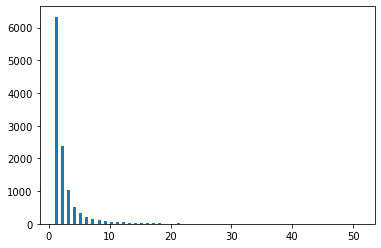

In [78]:
plt.hist(bikes_full_c_2['count'], bins=100);

More than half of the rides are just from different station combinations, very weird.

If we group by data for bikes using lat/long data on dataset with no row having Null station id, we still get a lot of different routes, this means that many docking stations are more than 12 m in lenghth which makes our job unnecessarily complicated, so I think its better to group by Station id only. 

In [64]:
zips = gpd.read_file(
    'Bay Area ZIP Codes/geo_export_c2aa1f49-1ef5-4a71-b07a-dc7e1ba2edd3.shp')
zips

,area,length,po_name,state,zip,geometry
0,1.231326e+10,995176.225313,NAPA,CA,94558,"POLYGON ((-122.10329 38.51328, -122.10348 38.5..."
1,9.917861e+08,200772.556587,FAIRFIELD,CA,94533,"POLYGON ((-121.94748 38.30151, -121.94718 38.2..."
2,7.236950e+09,441860.201400,DIXON,CA,95620,"POLYGON ((-121.65336 38.31339, -121.69340 38.3..."
3,3.001414e+09,311318.546326,SONOMA,CA,95476,"POLYGON ((-122.40684 38.15568, -122.40757 38.1..."
4,1.194302e+09,359104.646602,NAPA,CA,94559,"POLYGON ((-122.29369 38.15524, -122.29850 38.1..."
...,...,...,...,...,...,...
182,4.211365e+08,137369.776481,LOS ALTOS,CA,94022,"POLYGON ((-122.09598 37.38605, -122.09707 37.3..."
183,9.054792e+07,47415.860456,SUNNYVALE,CA,94085,"POLYGON ((-121.98689 37.38866, -121.98688 37.3..."
184,1.289431e+08,65560.361543,SUNNYVALE,CA,94086,"POLYGON ((-122.06000 37.37530, -122.05835 37.3..."
185,2.966973e+08,136286.642980,LOS ALTOS,CA,94024,"POLYGON ((-122.09598 37.38605, -122.09599 37.3..."


<AxesSubplot:>

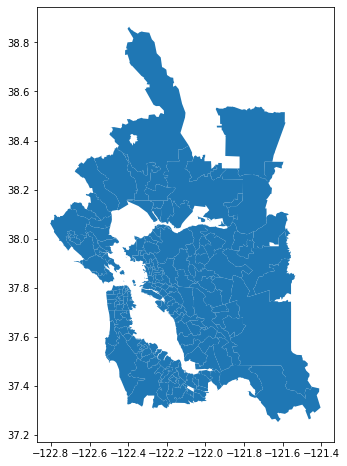

In [65]:
zips.plot(figsize=(8,8))